In [31]:
import os
import pandas as pd
import numpy as np
import yaml
import logging
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utilities.utilities import read_ac_data, add_gdp_cdd_data
from utilities.plotting import plot_exposure_contour

In [32]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

if not os.path.exists('Figures/exposure_function') :
    os.makedirs('Figures/exposure_function')

In [33]:
# Read the air conditioning data from the EIA and GDL

# EIA data of AC access from 2018
ac_data_eia = read_ac_data(config['ac_historical_file_iea'], 2018, skip=3)

# GDL data from multiple years
ac_data_gdl = read_ac_data(config['ac_historical_file_gdl'])

# Read OECD data
ac_data_oecd = read_ac_data(config['ac_historical_file_oecd'], 2011)

# Merge the two dataframes
ac_data = pd.concat([ac_data_oecd, ac_data_gdl, ac_data_eia])

ac_data = add_gdp_cdd_data(ac_data, config)

ac_data["GDP"] = pd.to_numeric(ac_data["GDP"], errors='coerce')

# If there are multiple entries for the same country, only keep the latest one
ac_data = ac_data.drop_duplicates('ISO3', keep='last')
ac_data = ac_data.dropna()

print(ac_data)

# Save the data to a csv file
ac_data.to_csv("air_conditioning_data.csv")


          country    AC  Year ISO3          CDD           GDP
0       Australia  0.75  2011  AUS   623.885159  45405.365365
1          Canada  0.48  2011  CAN   192.541180  45823.164240
3     Netherlands  0.11  2011  NLD    42.972056  52594.229006
4           Spain  0.54  2011  ESP   645.734562  36883.322978
5          Sweden  0.20  2011  SWE    33.849519  48947.439311
..            ...   ...   ...  ...          ...           ...
120        Mexico  0.16  2018  MEX  1143.255154  20278.216307
121        Brazil  0.16  2018  BRA  2050.512727  14619.591130
122     Indonesia  0.09  2018  IDN  2859.996393  11397.431401
123  South Africa  0.06  2018  ZAF   761.205911  13990.314893
124         India  0.05  2018  IND  2982.114970   6436.153402

[76 rows x 6 columns]


In [34]:
def sat(cdd, a):
    return 1. - np.exp(-a * cdd)

# Corrected avail function
def avail(gdp, b, c):
    return 1 / (1 + np.exp(b) * np.exp(-c * gdp))

# Adjusted exposure function to fit the curve_fit requirements
def ac_access(xdata, a, b, c):
    cdd, gdp = xdata
    return (sat(cdd, a) * avail(gdp, b, c))

def avail_alt(gdp, b, c):
    return (gdp**b / (gdp**b + c**b))

def ac_access_alt(xdata, a, b, c):
    cdd, gdp = xdata
    return (sat(cdd, a) * avail_alt(gdp, b, c))


# Prepare xdata as a tuple of CDD and GDP, ydata as AC
xdata = (ac_data["CDD"]/1000., ac_data["GDP"]/100000.)
ydata = ac_data["AC"]

# Fit the exposure function
popt, pcov = curve_fit(ac_access, xdata, ydata)

print(popt)

[4.36775505 2.57860166 8.21963785]


In [35]:
popt[0] /= 1000
popt[2] /= 100000
with open('exposure_function_params_exponential.pkl', 'wb') as f:
    pickle.dump({'cdd_scale': popt[0], 'alpha': popt[1], 'k': popt[2]}, f)
print(popt)

[4.36775505e-03 2.57860166e+00 8.21963785e-05]


In [36]:
# Add column to ac_data with the fitted exposure function
ac_data["AC calculated"] = sat(ac_data["CDD"], popt[0]) * avail(ac_data["GDP"], popt[1], popt[2])
print(ac_data)

          country    AC  Year ISO3          CDD           GDP  AC calculated
0       Australia  0.75  2011  AUS   623.885159  45405.365365       0.710333
1          Canada  0.48  2011  CAN   192.541180  45823.164240       0.435839
3     Netherlands  0.11  2011  NLD    42.972056  52594.229006       0.145674
4           Spain  0.54  2011  ESP   645.734562  36883.322978       0.574944
5          Sweden  0.20  2011  SWE    33.849519  48947.439311       0.111211
..            ...   ...   ...  ...          ...           ...            ...
120        Mexico  0.16  2018  MEX  1143.255154  20278.216307       0.284686
121        Brazil  0.16  2018  BRA  2050.512727  14619.591130       0.201477
122     Indonesia  0.09  2018  IDN  2859.996393  11397.431401       0.162223
123  South Africa  0.06  2018  ZAF   761.205911  13990.314893       0.186354
124         India  0.05  2018  IND  2982.114970   6436.153402       0.114095

[76 rows x 7 columns]


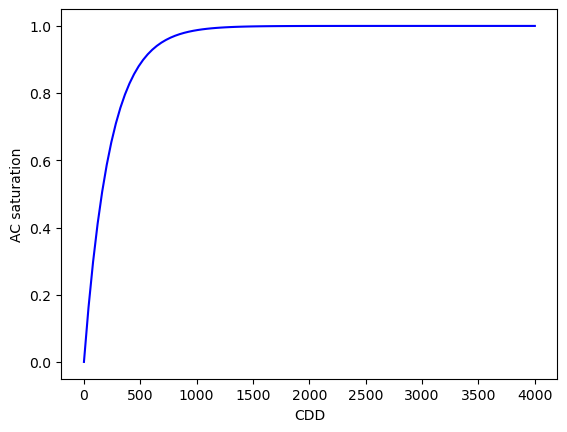

In [37]:
# Plot saturation function
cdd = np.linspace(0, 4000, 100)
plt.plot(cdd, sat(cdd, popt[0]), color='blue')
plt.xlabel("CDD")
plt.ylabel("AC saturation")
plt.savefig("Figures/exposure_function/saturation_exponential_fit.png")

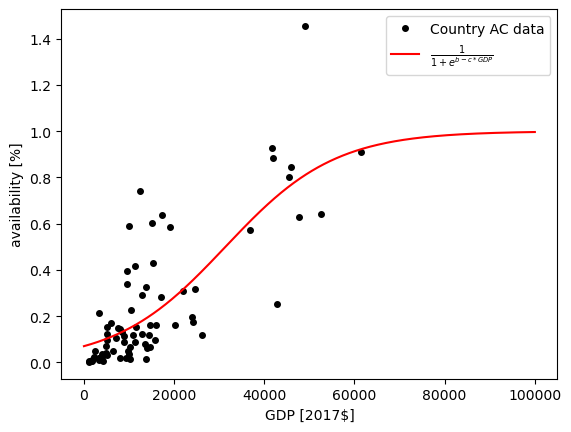

In [38]:
# Plot the availability function
fig, ax = plt.subplots()
ax.plot(ac_data["GDP"], ac_data["AC"]/sat(ac_data["CDD"], popt[0]), 'o', label="Country AC data", markersize=4, color='black')
x = np.linspace(0, 100000, 1000)
y = avail(x, popt[1], popt[2])
ax.plot(x, y, color='red', label=r'$\frac{1}{1+e^{b - c*GDP}}$')
ax.set_xlabel("GDP [2017$]")
ax.set_ylabel("availability [%]")
ax.legend()
plt.savefig("Figures/exposure_function/availability_exponential_fit.png")

In [39]:
# Alternative fit function

popt_gdp, pcov_gdp = curve_fit(ac_access_alt, xdata, ydata)

popt_gdp[0] /= 1000
popt_gdp[2] *= 100000

with open('exposure_function_params_power_law.pkl', 'wb') as f:
    pickle.dump({'cdd_scale': popt_gdp[0], 'alpha': popt_gdp[1], 'k': popt_gdp[2]}, f)

print(popt_gdp)

[4.95607091e-03 1.58506566e+00 2.99247514e+04]


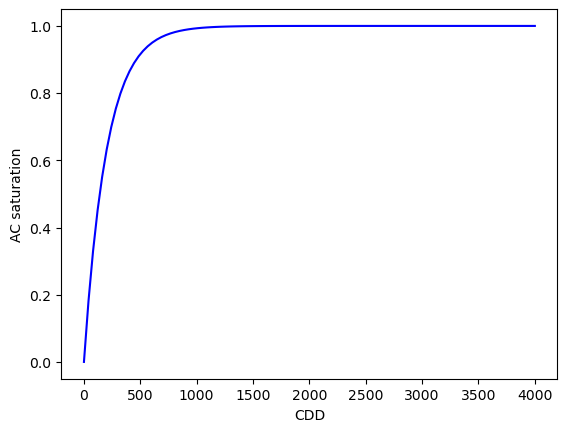

In [40]:
# Plot saturation function
cdd = np.linspace(0, 4000, 100)
plt.plot(cdd, sat(cdd, popt_gdp[0]), color='blue')
plt.xlabel("CDD")
plt.ylabel("AC saturation")
plt.savefig("Figures/exposure_function/saturation_power_fit.png")

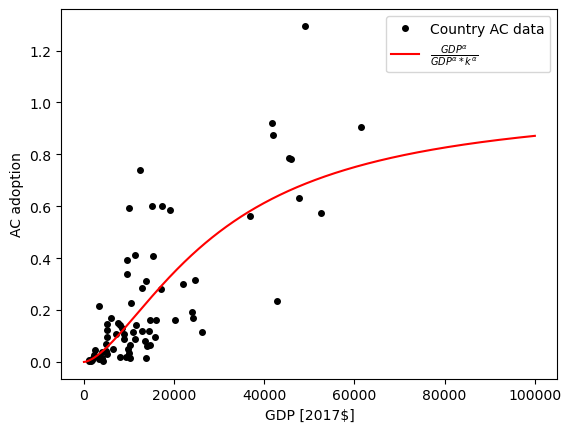

In [41]:
# Plot the fit
fig, ax = plt.subplots()
gdp_range = np.linspace(0, 100000., 1000)
ax.plot(ac_data["GDP"], ac_data["AC"]/sat(ac_data["CDD"], popt_gdp[0]), 'o', markersize=4, color="black", label="Country AC data")
ax.plot(gdp_range, avail_alt(gdp_range, popt_gdp[1], popt_gdp[2]), color="red", label=r"$\frac{GDP^{\alpha}}{GDP^{\alpha} * k^{\alpha}}$")
ax.set_xlabel("GDP [2017$]")
ax.set_ylabel("AC adoption")
ax.legend()
# Save the plot
plt.savefig("Figures/exposure_function/availability_power_fit.png")